In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import os

Matplotlib is building the font cache; this may take a moment.


## Helper Functions

In [1]:
def get_patches(file_name,patch_size,crop_sizes):
    '''This functions creates and return patches of given image with a specified patch_size'''
    image = cv2.imread(file_name) 
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    height, width , channels= image.shape
    patches = []
    for crop_size in crop_sizes: #We will crop the image to different sizes
        crop_h, crop_w = int(height*crop_size),int(width*crop_size)
        image_scaled = cv2.resize(image, (crop_w,crop_h), interpolation=cv2.INTER_CUBIC)
        for i in range(0, crop_h-patch_size+1, patch_size):
            for j in range(0, crop_w-patch_size+1, patch_size):
              x = image_scaled[i:i+patch_size, j:j+patch_size] # This gets the patch from the original image with size patch_size x patch_size
              patches.append(x)
    return patches

def create_image_from_patches(patches,image_shape):
  '''This function takes the patches of images and reconstructs the image'''
  image=np.zeros(image_shape) # Create a image with all zeros with desired image shape
  patch_size=patches.shape[1]
  p=0
  for i in range(0,image.shape[0]-patch_size+1,patch_size):
    for j in range(0,image.shape[1]-patch_size+1,patch_size):
      image[i:i+patch_size,j:j+patch_size]=patches[p] # Assigning values of pixels from patches to image
      p+=1
  return np.array(image)

In [2]:
def predict_fun(model,image_path,noise_level=30):
  #Creating patches for test image
  patches=get_patches(image_path,40,[1])
  test_image=cv2.imread(image_path)

  patches=np.array(patches)
  ground_truth=create_image_from_patches(patches,test_image.shape)

  #predicting the output on the patches of test image
  patches = patches.astype('float32') /255.
  patches_noisy = patches+ tf.random.normal(shape=patches.shape,mean=0,stddev=noise_level/255) 
  patches_noisy = tf.clip_by_value(patches_noisy, clip_value_min=0., clip_value_max=1.)
  noisy_image=create_image_from_patches(patches_noisy,test_image.shape)

  denoised_patches=model.predict(patches_noisy)
  denoised_patches=tf.clip_by_value(denoised_patches, clip_value_min=0., clip_value_max=1.)

  #Creating entire denoised image from denoised patches
  denoised_image=create_image_from_patches(denoised_patches,test_image.shape)

  return patches_noisy,denoised_patches,ground_truth/255.,noisy_image,denoised_image


def plot_patches(patches_noisy,denoised_patches):
  fig, axs = plt.subplots(2,10,figsize=(20,4))
  for i in range(10):

    axs[0,i].imshow(patches_noisy[i])
    axs[0,i].title.set_text(' Noisy')
    axs[0,i].get_xaxis().set_visible(False)
    axs[0,i].get_yaxis().set_visible(False)

    axs[1,i].imshow(denoised_patches[i])
    axs[1,i].title.set_text('Denoised')
    axs[1,i].get_xaxis().set_visible(False)
    axs[1,i].get_yaxis().set_visible(False)
  plt.show()

def plot_predictions(ground_truth,noisy_image,denoised_image):
  fig, axs = plt.subplots(1,3,figsize=(15,15))
  axs[0].imshow(ground_truth)
  axs[0].title.set_text('Ground Truth')
  axs[1].imshow(noisy_image)
  axs[1].title.set_text('Noisy Image')
  axs[2].imshow(denoised_image)
  axs[2].title.set_text('Denoised Image')
  plt.show()


#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
def PSNR(gt, image, max_value=1):
    """"Function to calculate peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((gt - image) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [7]:
print(tf.__version__)

2.3.0


## Model with different noise levels

In [8]:
dncnn=tf.keras.models.load_model('dncnn.h5')

In [6]:
noise_levels=[i for i in range(5,70,5)]
psnr_noisy=[]
psnr_denoised=[]
for i in noise_levels:
  patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(dncnn,'227092.jpg',noise_level=i)
  psnr_denoised.append(PSNR(ground_truth,denoised_image))
  psnr_noisy.append(PSNR(ground_truth,noisy_image))

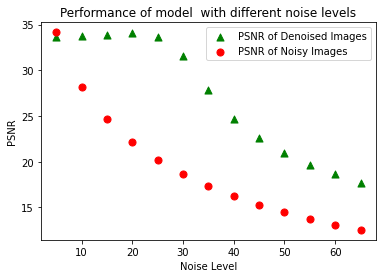

In [7]:
plt.scatter(noise_levels,psnr_denoised,marker='^',s=50,c='green',label='PSNR of Denoised Images')
plt.scatter(noise_levels,psnr_noisy,marker='o',s=50,c='red',label='PSNR of Noisy Images')
#plt.axhline(20.2044,linestyle='--',label='PSNR of Noisy Image')
plt.xlabel('Noise Level')
plt.ylabel('PSNR')
plt.title('Performance of model  with different noise levels')
plt.legend()
plt.show()

<h3><b>
<p>Peak signal-to-noise ratio (PSNR) is the ratio between the maximum possible power of an image and the power of corrupting noise that affects the quality of its representation. More the PSNR more closer the denoised image to the ground truth image.</p>

<p>In the above cell we have plotted increase in PSNR of predicted image with a given noisy image.</p>
<p>We can observe that model is performing well on the images with noise levels in range of 10-35. As the noise levels are increased there is very little improvement in the PSNR.</p>

<p>Above noise level 60 it is difficult for the model to reconstruct the image from the given noisy image.</P></b>
</h3>

## Model performance on different images

PSNR of Noisy Image :  20.702885216826658
PSNR of Denoised Image :  36.87139875129621


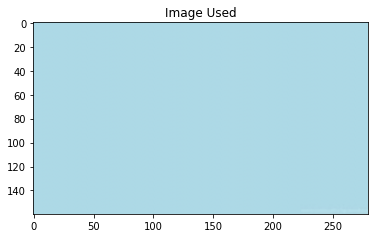

In [60]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(dncnn,'blue.jpg',noise_level=25)
plt.imshow(ground_truth)
plt.title('Image Used')
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))

PSNR of Noisy Image :  20.21861344587648
PSNR of Denoised Image :  33.717728409381124


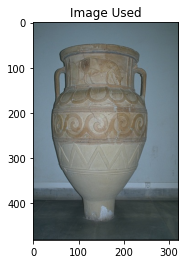

In [61]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(dncnn,'227092.jpg',noise_level=25)
plt.imshow(ground_truth)
plt.title('Image Used')
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))

PSNR of Noisy Image :  20.911137038089077
PSNR of Denoised Image :  31.35115326057757


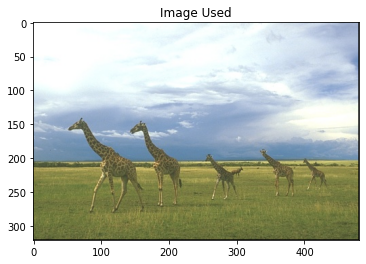

In [62]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(dncnn,'253055.jpg',noise_level=25)
plt.imshow(ground_truth)
plt.title('Image Used')
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))

PSNR of Noisy Image :  20.39187227389304
PSNR of Denoised Image :  29.32881887430633


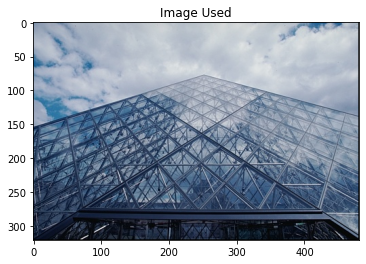

In [63]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(dncnn,'223061.jpg',noise_level=25)
plt.imshow(ground_truth)
plt.title('Image Used')
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))

PSNR of Noisy Image :  20.310072474332582
PSNR of Denoised Image :  29.40282495533914


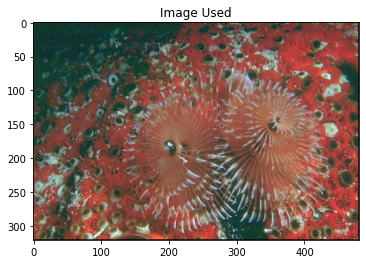

In [64]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(dncnn,'12084.jpg',noise_level=25)
plt.imshow(ground_truth)
plt.title('Image Used')
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))

PSNR of Noisy Image :  20.39105923631544
PSNR of Denoised Image :  28.038285157043976


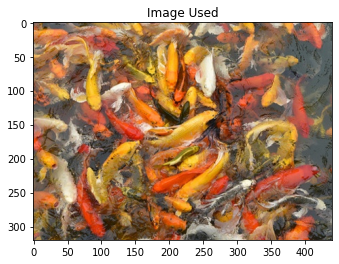

In [66]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(dncnn,'fish.jpg',noise_level=25)
plt.imshow(ground_truth)
plt.title('Image Used')
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))

<h3><b>
<p>Above we have seen the model performance of various images.</p>
<p>The model tries to predict the residues in image by looking at the pixels that are distributed around a pixel.</p> 
<p>In the plain blue image model gave the highest performance this is because all the pixels are of same value and it is easier for the model to extract residue out the plain background images
</p>
<p>In the final image of fishes model gave the least performance this is because the image consists of varying colors with lots of details making difficult for the model to get the residues.</p>
<p>We can see the model performance decreases with increase in complexity of image in terms of color variations and pixel distributions</p>
<p>However this impact is negotiable as we are reconstructing image by predicting on smaller patches of image.</p>
</b></h3>

## Test time on CPU vs GPU

In [7]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(dncnn,'227092.jpg',noise_level=25)
test_patch=tf.expand_dims(patches_noisy[0],axis=0)

In [20]:
##CPU
start = time.time()
predicted=dncnn.predict(test_patch)
end=time.time()
print('Time taken on CPU: ',end-start)

Time taken on CPU:  0.10502743721008301


In [35]:
##GPU
start = time.time()
predicted=dncnn.predict(test_patch)
end=time.time()
print('Time taken on GPU: ',end-start)

Time taken on GPU:  0.03835892677307129


<h3><b>
<p>Time taken for denoising a single patch on CPU is 0.1 seconds whereas on GPU it is 0.03 seconds.</p>
<p>However an image can have varying size and can have different predicting times depending on number of patches the image is split into.</p>
</b></h3>

## TFLite

In [9]:
#https://stackoverflow.com/questions/51966486/different-predictions-when-running-keras-model-in-tensorflow-lite
#https://www.tensorflow.org/lite/convert

converter = tf.lite.TFLiteConverter.from_keras_model(dncnn)

tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\SUNIL\AppData\Local\Temp\tmp7mljhoiw\assets


In [10]:
with open(f'dncnn2.tflite', 'wb') as f:
    f.write(tflite_model)

In [75]:
f = tf.lite.Interpreter(f'dncnn.tflite')
f.allocate_tensors()
i = f.get_input_details()[0]
o = f.get_output_details()[0]

In [83]:
start=time.time()
f.set_tensor(i['index'], tf.expand_dims(patches_noisy[0],axis=0))
f.invoke()
y = f.get_tensor(o['index'])
end=time.time()
print('Time for prediction with optimized model ',end-start)

Time for prediction with optimized model  0.03671717643737793


In [89]:
file_name = "dncnn.h5"
file_stats = os.stat(file_name)
print(f'File Size of original model in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

File Size in MegaBytes is 7.588813781738281


In [91]:
file_name = "dncnn.tflite"
file_stats = os.stat(file_name)
print(f'File Size of optimized model in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

File Size of optimized model in MegaBytes is 2.419788360595703


<h3><b>
<p>Time taken for prediction with original model and optimized model is same i.e, 0.03 seconds.</p>
<p>The file size of original  model is reduced by 5 MB after optimization.</P>
</b></h3>